# Application of Explainable Machine Learning on Prediction

## Dataset: Credit

*   20 Features
*   Predict class: good, bad

### Loading Packages

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=2f2832a703a8a73b8c233e748abd4b7d93efe21e3cb51bf4f3ff13b00435d408
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from scipy.stats import uniform, randint
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import lime
import lime.lime_tabular
import shap

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [ ]:
# Load the data
credit = pd.read_csv('credit.csv')
credit = credit.drop(columns = 'Unnamed: 0')
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [ ]:
# Check missing data
credit.isnull().sum()
# Again make sure there's no missing value
assert credit.isna().sum().sum() == 0

There's no missing value.

### Data Visualization

In [ ]:
credit.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

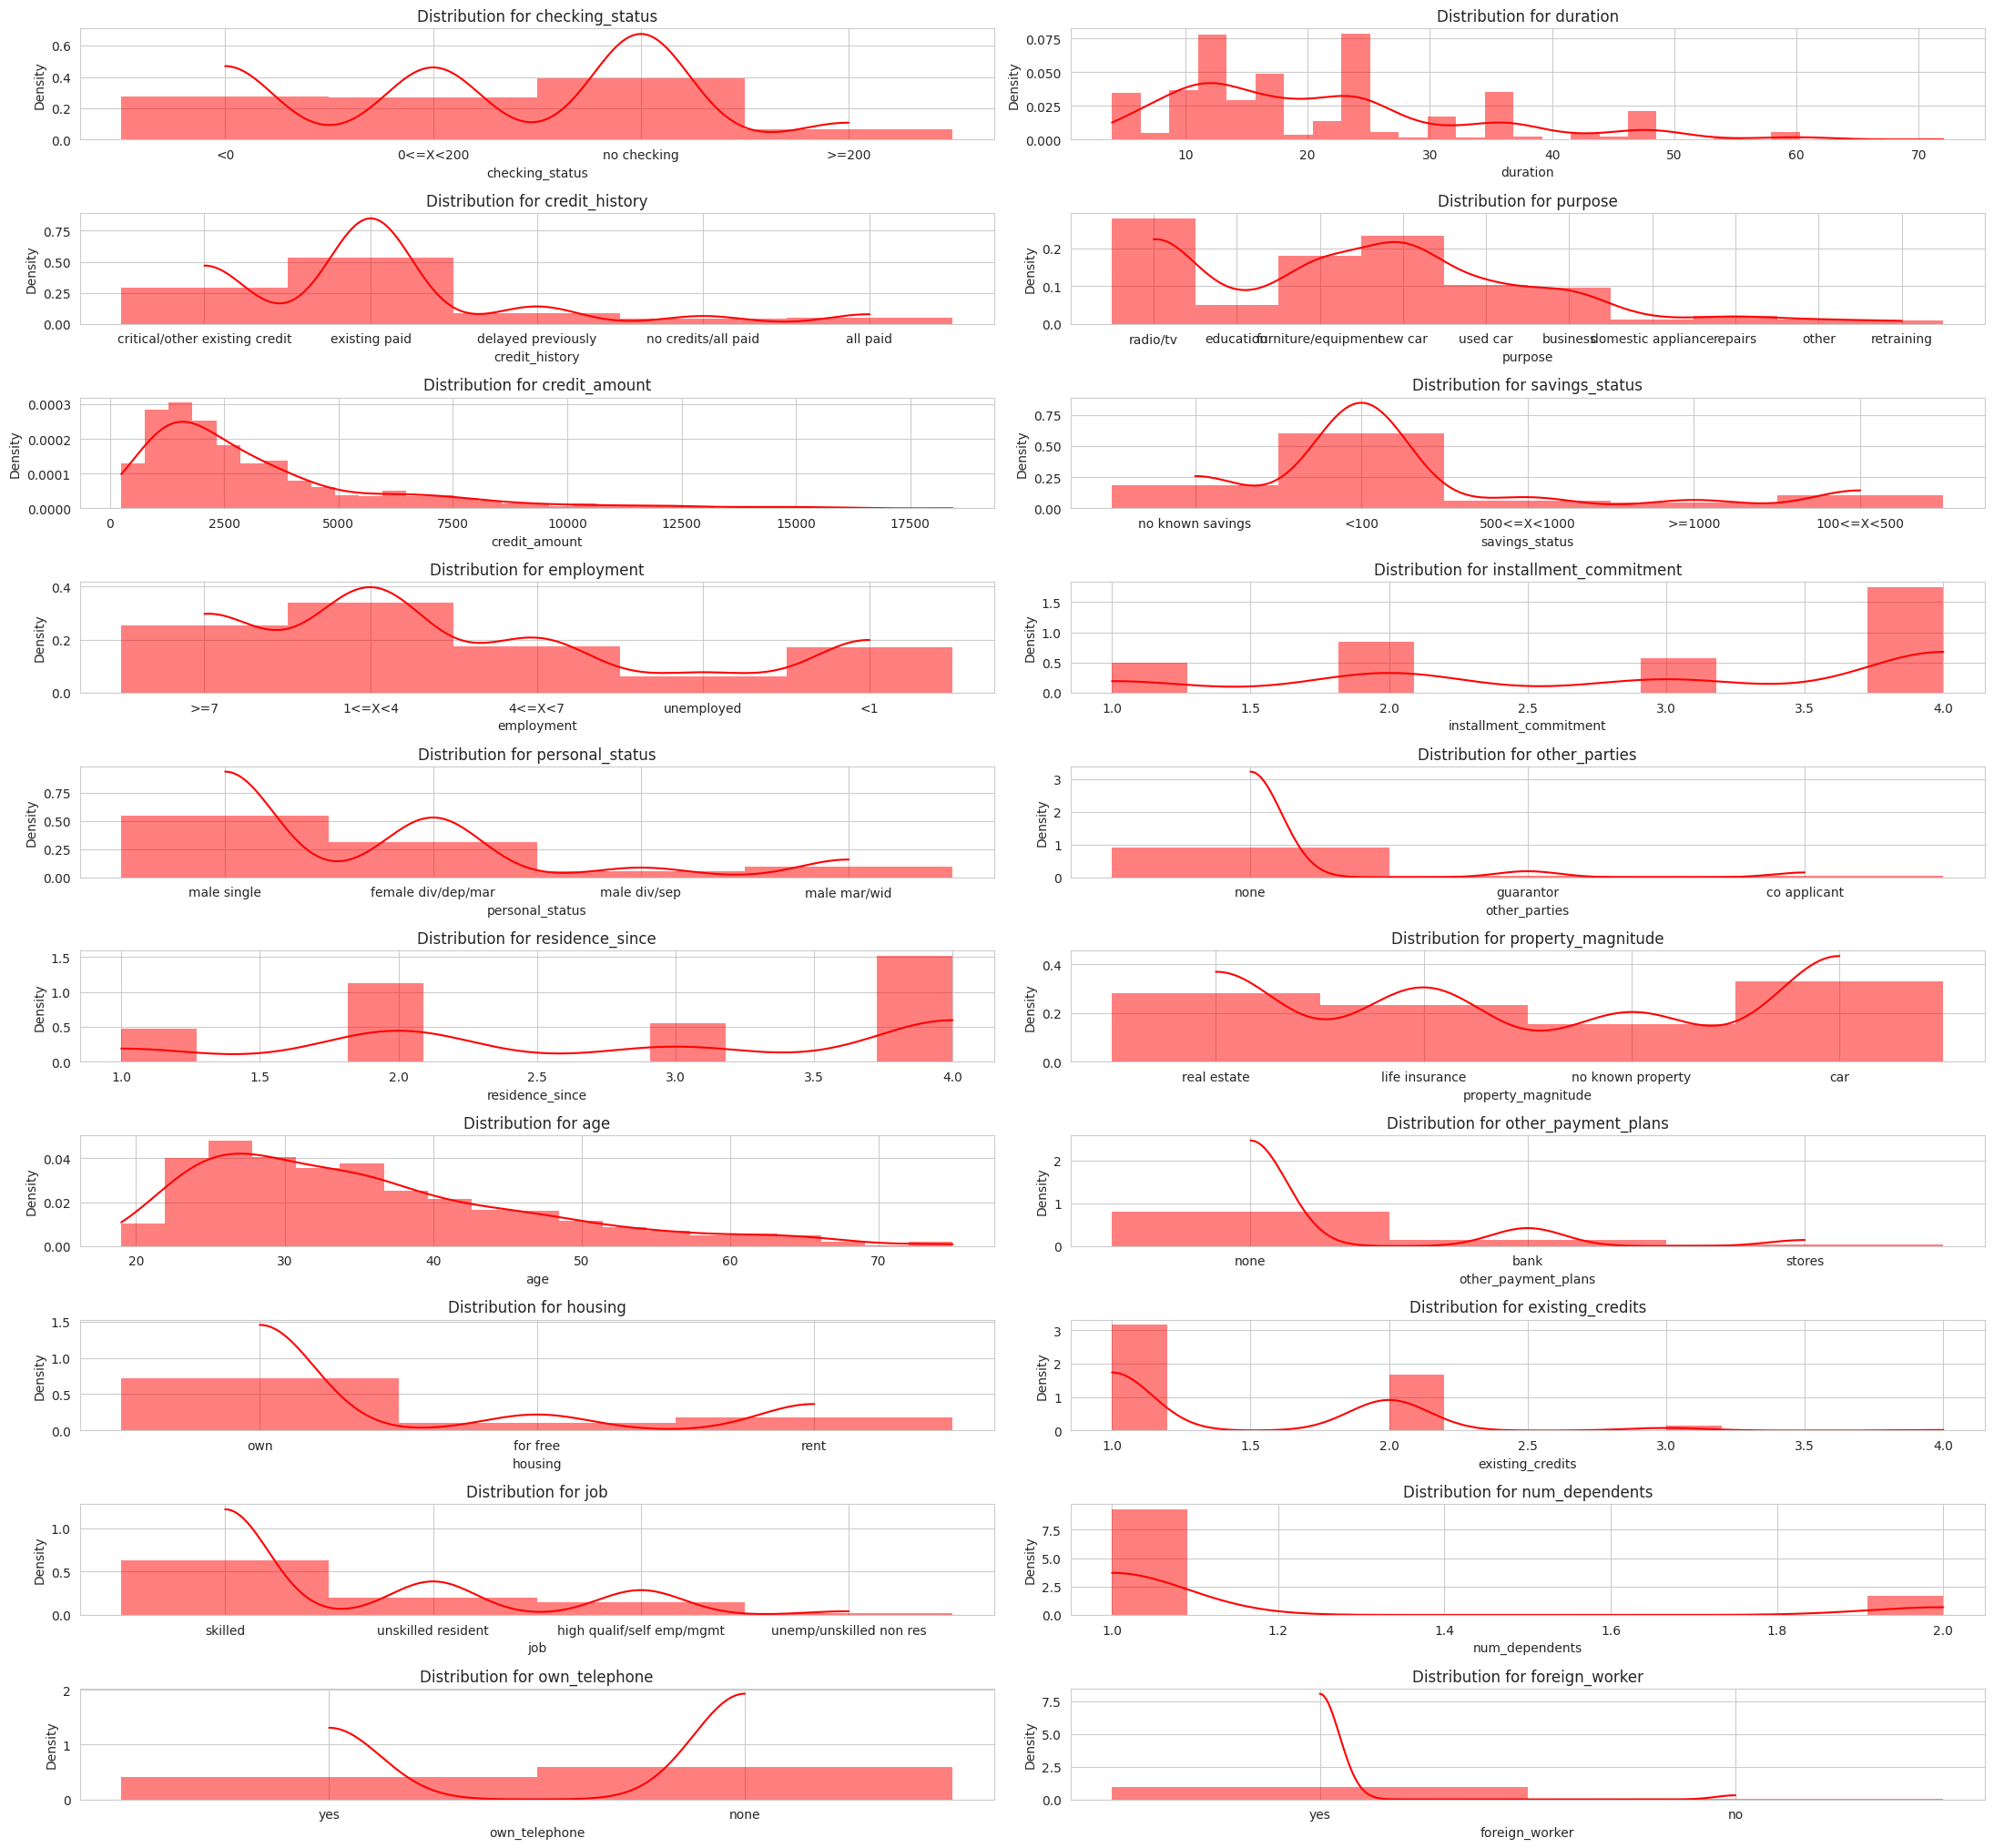

In [ ]:
# Select features
features = ['checking_status', 'duration', 'credit_history',
       'purpose', 'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker']

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Plot layout
n_rows = 11
n_cols = 2
plt.figure(figsize=(22, 22))

# Loop through the features and create a histogram for each
for i, feature in enumerate(features):
  plt.subplot(n_rows, n_cols, i + 1)
  sns.histplot(credit[feature], kde=True, color='red', stat="density", linewidth=0)
  plt.title(f'Distribution for {feature}')
  plt.xlabel(feature)
  plt.ylabel('Density')

# Display the plots
plt.tight_layout()
plt.show()

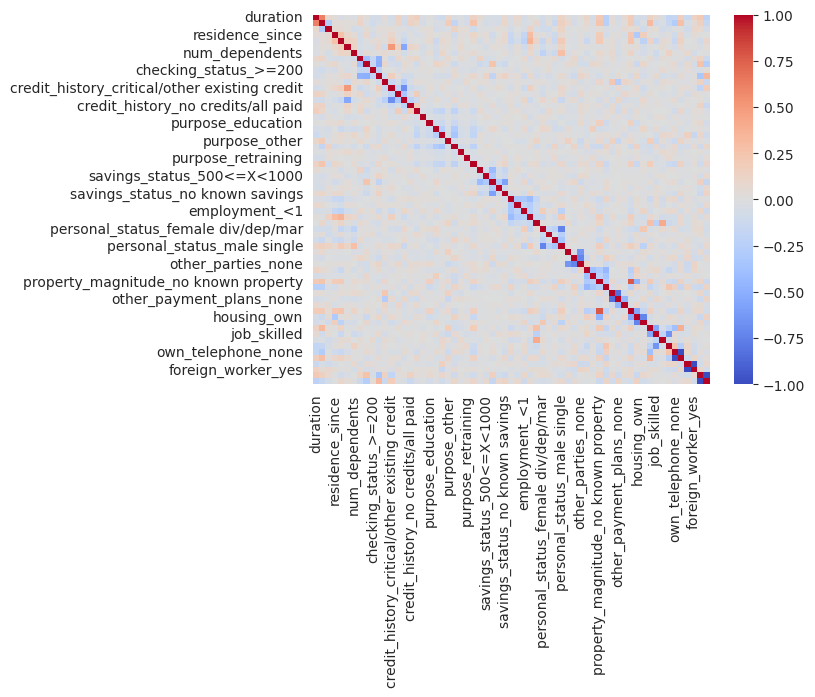

In [ ]:
# Correlation Map
credit_encoded = pd.get_dummies(credit)

# Now calculate the correlation matrix
corr = credit_encoded.corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

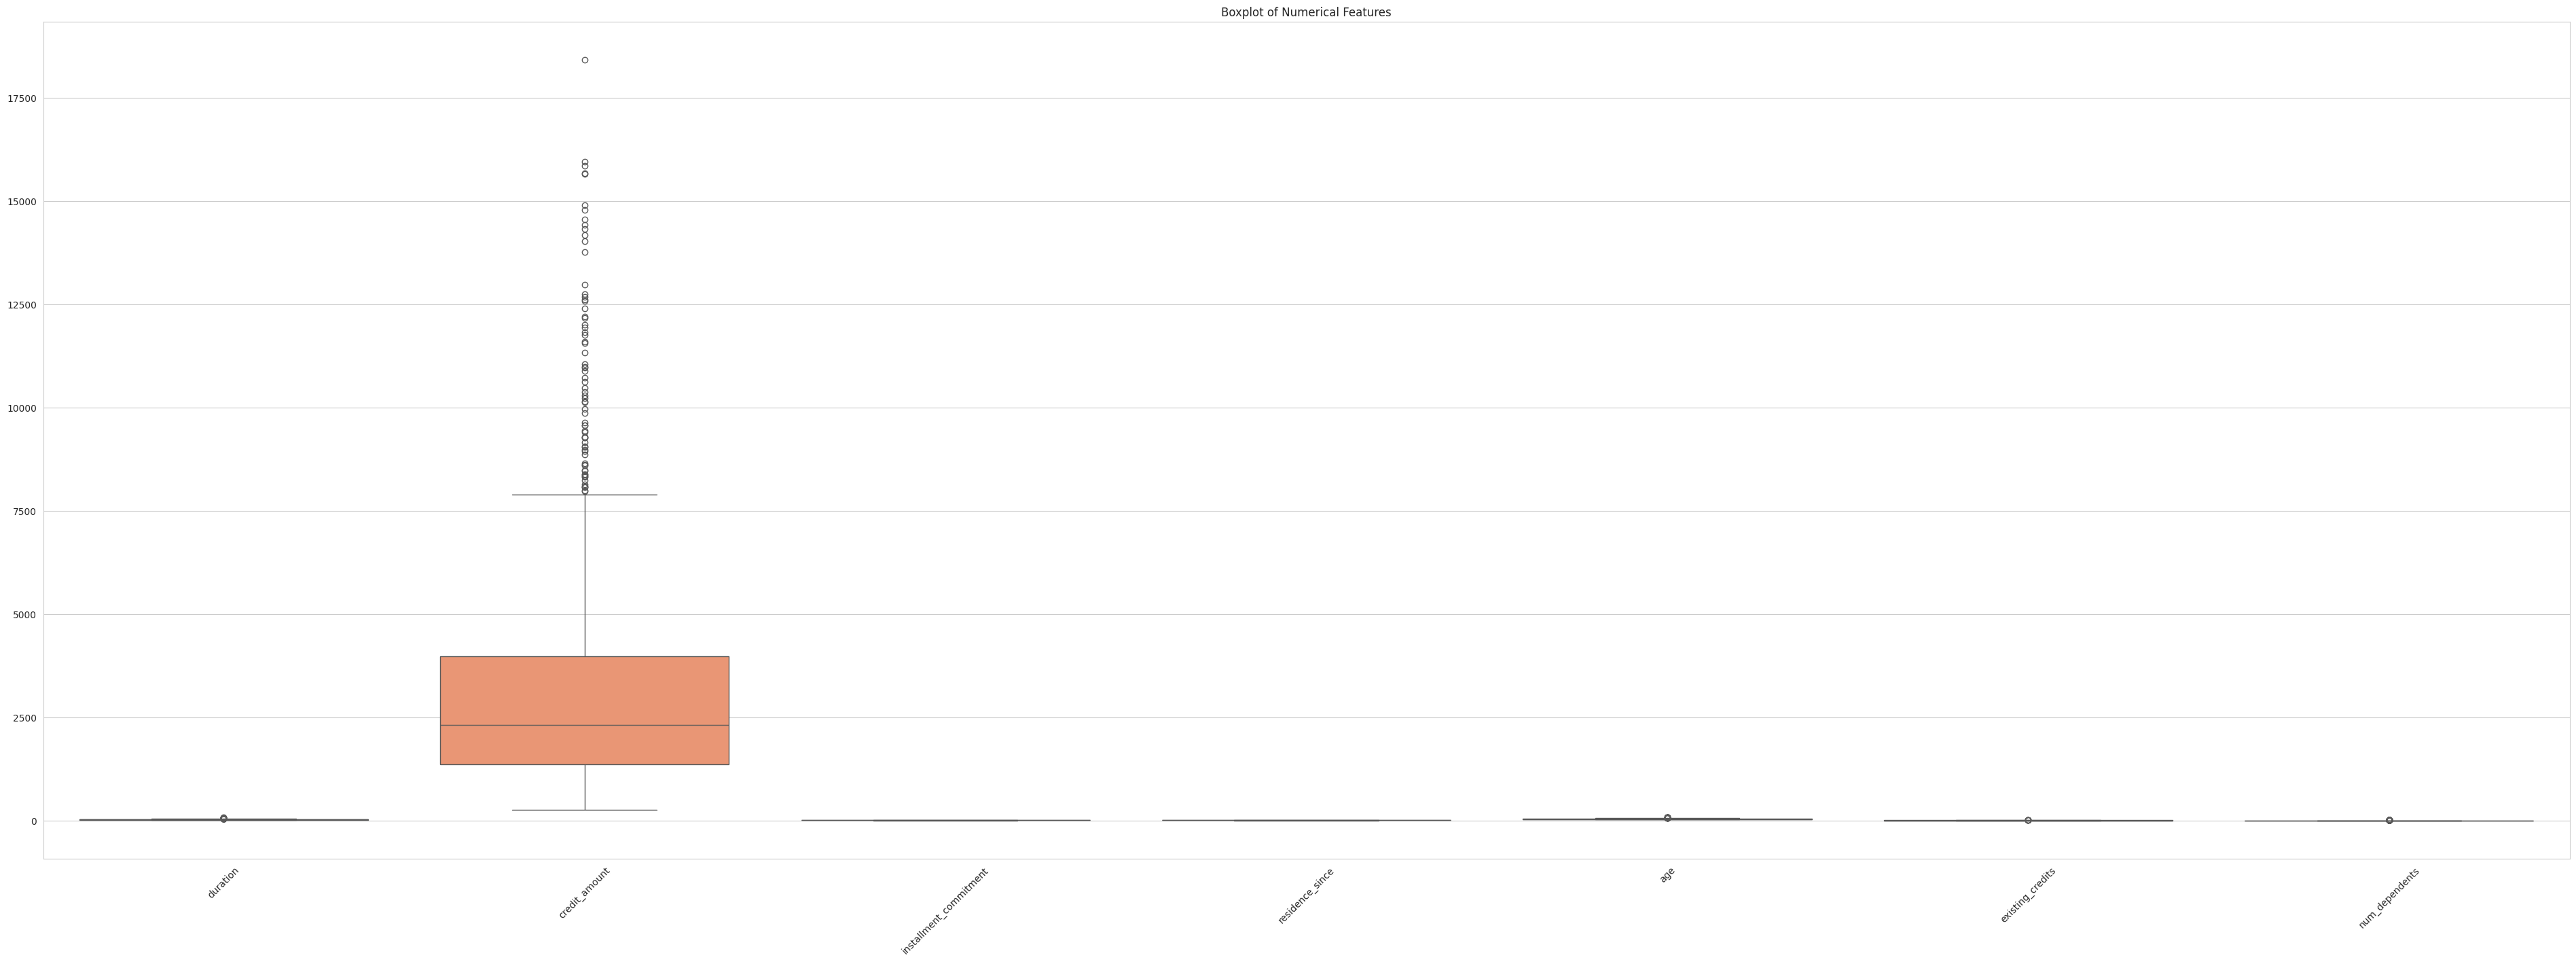

In [ ]:
# Plotting boxplot for all numerical features
plt.figure(figsize=(48, 16))
sns.boxplot(data=credit[['checking_status', 'duration', 'credit_history',
       'purpose', 'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker']], palette="Set2")
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

The scales of each features differ, and thus standardization is needed.

### Data Preprocessing

In [ ]:
# Identify features and labels
X = credit.drop('class', axis=1)
y = credit['class']

# Standardize the numerical variables
scaler = StandardScaler()

# Split the data
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Columns that you might consider for one-hot encoding
categorical_columns = [
    'checking_status', 'credit_history', 'purpose', 'savings_status', 'employment',
    'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans',
    'housing', 'job', 'own_telephone', 'foreign_worker'
]

# Applying one-hot encoding
X_train_unscaled = pd.get_dummies(X_train_unscaled, columns=categorical_columns, drop_first=True)
X_test_unscaled = pd.get_dummies(X_test_unscaled, columns=categorical_columns, drop_first=True)

# Ensuring both datasets have the same dummy columns in case the test set lacks some categories
X_train_unscaled, X_test_unscaled = X_train_unscaled.align(X_test_unscaled, join='inner', axis=1)

X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.fit_transform(X_test_unscaled)

### Model Building & Evaluation

In [ ]:
num_unique_values = credit['class'].nunique()
print(f"Number of unique values in 'column_name': {num_unique_values}")

Number of unique values in 'column_name': 2


#### Logistic Regression

In [ ]:
# Logistic Regression
label_encoder = LabelEncoder()
label_encoder.fit(y)

lr_model = LogisticRegression(random_state = 42)
lr_model.fit(X_train, y_train)

# Prediction
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

# Evaluation
class_names = [str(cls) for cls in label_encoder.classes_]
lr_report = classification_report(y_test, y_pred_lr, target_names = class_names)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
log_loss_lr = log_loss(y_test, y_pred_proba_lr)

# Results
print('Logistics Regression Evaluation\n')
print(lr_report)
print(f'Accuracy: {accuracy_lr}\nLog Loss: {log_loss_lr}')

Logistics Regression Evaluation

              precision    recall  f1-score   support

         bad       0.74      0.58      0.65        59
        good       0.84      0.91      0.87       141

    accuracy                           0.81       200
   macro avg       0.79      0.75      0.76       200
weighted avg       0.81      0.81      0.81       200

Accuracy: 0.815
Log Loss: 0.45710541191918624


#### KNN

In [ ]:
# KNN
knn = KNeighborsClassifier()

# Find best n_neighbors by cross-validation
k_grid = {'n_neighbors': range(1, 30),
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']
          }
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn_cv = GridSearchCV(knn, k_grid, cv=kf)

# Train model
knn_cv.fit(X_train, y_train)
knn_model = knn_cv.best_estimator_ # best KNN model

# Prediction
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)

# Evaluation
knn_report = classification_report(y_test, y_pred_knn, target_names = class_names)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
log_loss_knn = log_loss(y_test, y_pred_proba_knn)

# Results
print('K-Nearest Neighbors Evaluation\n')
print(knn_report)
print(f'Accuracy: {accuracy_knn}\nLog Loss: {log_loss_knn}')

K-Nearest Neighbors Evaluation

              precision    recall  f1-score   support

         bad       0.60      0.31      0.40        59
        good       0.76      0.91      0.83       141

    accuracy                           0.73       200
   macro avg       0.68      0.61      0.62       200
weighted avg       0.71      0.73      0.70       200

Accuracy: 0.735
Log Loss: 0.4926166379338875


#### SVM

In [ ]:
# Support Vector Machine
svm_model = SVC(probability=True, random_state = 42)
svm_model.fit(X_train, y_train)

# Prediction
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)

# Evaluation
svm_report = classification_report(y_test, y_pred_svm, target_names = class_names)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
log_loss_svm = log_loss(y_test, y_pred_proba_svm)

# Results
print('Support Vector Machine Evaluation\n')
print(svm_report)
print(f'Accuracy: {accuracy_svm}\nLog Loss: {log_loss_svm}')

Support Vector Machine Evaluation

              precision    recall  f1-score   support

         bad       0.80      0.41      0.54        59
        good       0.79      0.96      0.87       141

    accuracy                           0.80       200
   macro avg       0.80      0.68      0.70       200
weighted avg       0.80      0.80      0.77       200

Accuracy: 0.795
Log Loss: 0.4786845380948435


#### Decision Tree

In [ ]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# Prediction
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)

# Evaluation
dt_report = classification_report(y_test, y_pred_dt, target_names = class_names)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
log_loss_dt = log_loss(y_test, y_pred_proba_dt)

# Results
print('Logistics Regression Evaluation\n')
print(dt_report)
print(f'Accuracy: {accuracy_dt}\nLog Loss: {log_loss_dt}')

Logistics Regression Evaluation

              precision    recall  f1-score   support

         bad       0.65      0.41      0.50        59
        good       0.79      0.91      0.84       141

    accuracy                           0.76       200
   macro avg       0.72      0.66      0.67       200
weighted avg       0.74      0.76      0.74       200

Accuracy: 0.76
Log Loss: 0.5120019569624403


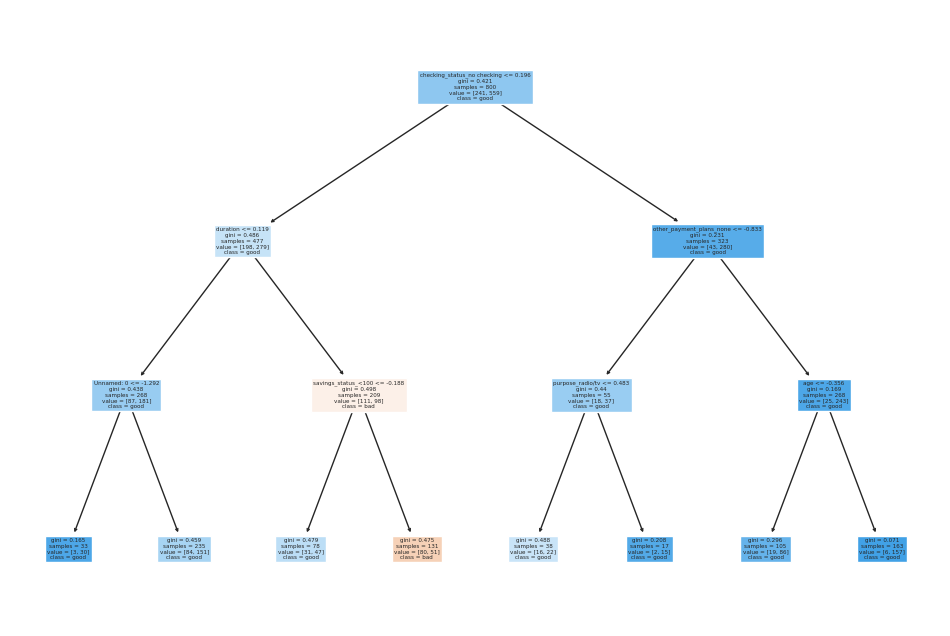

In [ ]:
# Visualize Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt_model, filled=True, feature_names = X_train_unscaled.columns.tolist(), class_names = class_names)
plt.show()

#### Random Forest

In [ ]:
# Random Forest
# Find best model through cross validation
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

rf_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
           'max_features': ['auto', 'sqrt'],
           'max_depth': max_depth,
           'min_samples_split': randint(2,20),
           'min_samples_leaf': randint(1,10),
           'bootstrap': [True, False]}

rf_cv = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 42),
                           param_distributions = rf_grid,
                           n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Train model
rf_cv.fit(X_train, y_train)
rf_model = rf_cv.best_estimator_ # best random forest model

# Prediction
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# Evaluation
rf_report = classification_report(y_test, y_pred_rf, target_names = class_names)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
log_loss_rf = log_loss(y_test, y_pred_proba_rf)

# Results
print('Random Forest Evaluation (Baseline)\n')
print(rf_report)
print(f'Accuracy: {accuracy_rf}\nLog Loss: {log_loss_rf}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Random Forest Evaluation (Baseline)

              precision    recall  f1-score   support

         bad       0.74      0.39      0.51        59
        good       0.79      0.94      0.86       141

    accuracy                           0.78       200
   macro avg       0.76      0.67      0.68       200
weighted avg       0.77      0.78      0.76       200

Accuracy: 0.78
Log Loss: 0.48410209675258925


#### AdaBoost

In [ ]:
# AdaBoost
ab_model = AdaBoostClassifier(random_state = 42)
ab_model.fit(X_train, y_train)

# Prediction
y_pred_ab = ab_model.predict(X_test)
y_pred_proba_ab = ab_model.predict_proba(X_test)

# Evaluation
ab_report = classification_report(y_test, y_pred_ab, target_names = class_names)
accuracy_ab = accuracy_score(y_test, y_pred_ab)
log_loss_ab = log_loss(y_test, y_pred_proba_ab)

# Results
print('AdaBoost Evaluation\n')
print(ab_report)
print(f'Accuracy: {accuracy_ab}\nLog Loss: {log_loss_ab}')

AdaBoost Evaluation

              precision    recall  f1-score   support

         bad       0.67      0.61      0.64        59
        good       0.84      0.87      0.86       141

    accuracy                           0.80       200
   macro avg       0.75      0.74      0.75       200
weighted avg       0.79      0.80      0.79       200

Accuracy: 0.795
Log Loss: 0.6755095201230182


#### XGBoost

In [ ]:
# Assuming you have previously fitted label_encoder with all possible classes
label_encoder = LabelEncoder()
all_labels = pd.concat([y_train, y_test])  # Temporarily combine to cover all potential labels
label_encoder.fit(all_labels)
y_test_encoded = label_encoder.transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

# XGBoost
xgb_grid = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0.5, 1),
    'min_child_weight': randint(1, 5),
    'subsample': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.4),
    'reg_alpha': uniform(0, 40),
    'reg_lambda': uniform(0, 1)
}

xgb_cv = RandomizedSearchCV(
    XGBClassifier(objective='multi:softprob', num_class=2), # multiclass classification
    param_distributions = xgb_grid,
    n_iter = 100,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5,
    verbose = 3,
    random_state = 42
)

# Train model
xgb_cv.fit(X_train, y_train_encoded)
xgb_model = xgb_cv.best_estimator_ # best XGBoost model

# Prediction
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)
y_pred_xgb = np.argmax(y_pred_xgb, axis=1)

# Evaluation
xgb_report = classification_report(y_test_encoded, y_pred_xgb, target_names = class_names)
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
log_loss_xgb = log_loss(y_test_encoded, y_pred_proba_xgb)

# Results
print('XGBoost Evaluation\n')
print(xgb_report)
print(f'Accuracy: {accuracy_xgb}\nLog Loss: {log_loss_xgb}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
XGBoost Evaluation

              precision    recall  f1-score   support

         bad       1.00      0.05      0.10        59
        good       0.72      1.00      0.83       141

    accuracy                           0.72       200
   macro avg       0.86      0.53      0.47       200
weighted avg       0.80      0.72      0.62       200

Accuracy: 0.72
Log Loss: 0.5623736385510031


#### Neural Network

Epoch 1/25
20/20 [==============================] - 2s 21ms/step - loss: 0.6146 - accuracy: 0.6969 - val_loss: 0.5763 - val_accuracy: 0.6938
Epoch 2/25
20/20 [==============================] - 0s 5ms/step - loss: 0.5174 - accuracy: 0.7563 - val_loss: 0.5418 - val_accuracy: 0.7188
Epoch 3/25
20/20 [==============================] - 0s 6ms/step - loss: 0.4642 - accuracy: 0.7766 - val_loss: 0.5324 - val_accuracy: 0.7125
Epoch 4/25
20/20 [==============================] - 0s 6ms/step - loss: 0.4343 - accuracy: 0.7937 - val_loss: 0.5353 - val_accuracy: 0.7312
Epoch 5/25
20/20 [==============================] - 0s 5ms/step - loss: 0.4079 - accuracy: 0.8016 - val_loss: 0.5469 - val_accuracy: 0.7312
Epoch 6/25
20/20 [==============================] - 0s 6ms/step - loss: 0.3832 - accuracy: 0.8234 - val_loss: 0.5438 - val_accuracy: 0.7250
Epoch 7/25
20/20 [==============================] - 0s 5ms/step - loss: 0.3610 - accuracy: 0.8391 - val_loss: 0.5664 - val_accuracy: 0.7312
Epoch 8/25
20/20 [=

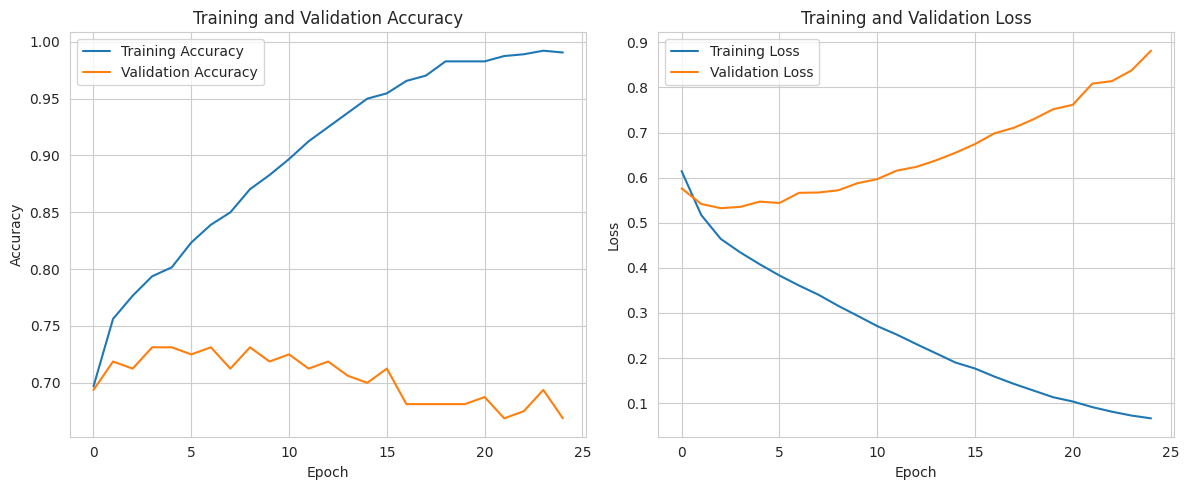

In [ ]:
# Neural Network
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

num_classes = 2
y_train_categ = to_categorical(y_train_encoded, num_classes)
y_test_categ = to_categorical(y_test_encoded, num_classes)

# Build model
neural_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]), # add layers
    Dense(64, activation='relu'),
    Dense(y_train_categ.shape[1], activation='softmax')
])

# Compile model
neural_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train model
history_neural = neural_model.fit(X_train, y_train_categ, epochs = 25,
                                  batch_size = 32, verbose = 1, validation_split=0.2)

# Traning Accuracy and Loss Visualization
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history_neural.history['accuracy'], label='Training Accuracy')
plt.plot(history_neural.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_neural.history['loss'], label='Training Loss')
plt.plot(history_neural.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prediction
y_pred_proba_neural = neural_model.predict(X_test)
y_pred_neural = np.argmax(y_pred_proba_neural, axis=1)
true_labels = np.argmax(y_test_categ, axis=1)

# Evaluation
neural_report = classification_report(true_labels, y_pred_neural, target_names = class_names)
log_loss_neural, accuracy_neural = neural_model.evaluate(X_test, y_test_categ)

# Results
print('Neural Network Evaluation\n')
print(neural_report)
print(f'Accuracy: {accuracy_neural}\nLog Loss: {log_loss_neural}')

7/7 [==============================] - 0s 4ms/step - loss: 0.7692 - accuracy: 0.7750
Neural Network Evaluation

              precision    recall  f1-score   support

         bad       0.62      0.59      0.61        59
        good       0.83      0.85      0.84       141

    accuracy                           0.78       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.77      0.78      0.77       200

Accuracy: 0.7749999761581421
Log Loss: 0.7691801190376282


### Model Selection

#### ROC Curve

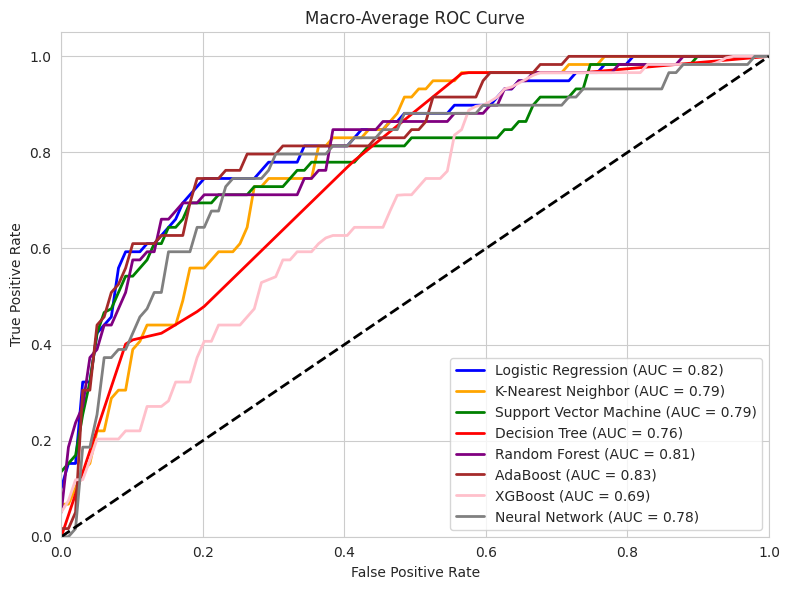

In [ ]:
# Macro-Average ROC Curve for Comparison
y_test_binarized = label_binarize(y_test, classes=['good', 'bad'])
fig, ax = plt.subplots(figsize=(8, 6))
colors = cycle(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])
model_predictions = [
    (y_pred_proba_lr, 'Logistic Regression'),
    (y_pred_proba_knn, 'K-Nearest Neighbor'),
    (y_pred_proba_svm, 'Support Vector Machine'),
    (y_pred_proba_dt, 'Decision Tree'),
    (y_pred_proba_rf, 'Random Forest'),
    (y_pred_proba_ab, 'AdaBoost'),
    (y_pred_proba_xgb, 'XGBoost'),
    (y_pred_proba_neural, 'Neural Network')
]

# Calculate and plot macro-average ROC curve and ROC area for each model
for model_proba, title in model_predictions:
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)
    num_classes = y_test_binarized.shape[1]

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], model_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    mean_tpr /= num_classes
    roc_auc = auc(all_fpr, mean_tpr)
    ax.plot(all_fpr, mean_tpr, color=next(colors), lw=2, label=f'{title} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Macro-Average ROC Curve')
ax.legend(loc="lower right")

# Display the plot
plt.tight_layout()
plt.show()

#### Performance Metrics

In [ ]:
# Model names
model = ['Logistic Regression', 'K-Nearest Neighbor', 'Support Vector Machine',
         'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 'Neural Network']
encoder = LabelEncoder()
encoder.fit(y_test)

# Performance metrics
performance = {
    'Accuracy': [accuracy_lr, accuracy_knn, accuracy_svm, accuracy_dt,
                 accuracy_rf, accuracy_ab, accuracy_xgb, accuracy_neural],
    'Log Loss': [log_loss_lr, log_loss_knn, log_loss_svm, log_loss_dt,
                 log_loss_rf, log_loss_ab, log_loss_xgb, log_loss_neural],
    'ROC AUC': [
        roc_auc_score(y_test, y_pred_proba_lr[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_knn[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_svm[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_dt[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_rf[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_ab[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_xgb[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_neural[:,1], multi_class='ovr', average='macro')
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='macro'),
        precision_score(y_test, y_pred_knn, average='macro'),
        precision_score(y_test, y_pred_svm, average='macro'),
        precision_score(y_test, y_pred_dt, average='macro'),
        precision_score(y_test, y_pred_rf, average='macro'),
        precision_score(y_test, y_pred_ab, average='macro'),
        precision_score(y_test, encoder.inverse_transform(y_pred_xgb), average='macro'),
        precision_score(y_test, encoder.inverse_transform(y_pred_neural), average='macro')
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='macro'),
        recall_score(y_test, y_pred_knn, average='macro'),
        recall_score(y_test, y_pred_svm, average='macro'),
        recall_score(y_test, y_pred_dt, average='macro'),
        recall_score(y_test, y_pred_rf, average='macro'),
        recall_score(y_test, y_pred_ab, average='macro'),
        recall_score(y_test, encoder.inverse_transform(y_pred_xgb), average='macro'),
        recall_score(y_test, encoder.inverse_transform(y_pred_neural), average='macro')
    ],
    'F1 Score (macro)': [
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_knn, average='macro'),
        f1_score(y_test, y_pred_svm, average='macro'),
        f1_score(y_test, y_pred_dt, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_ab, average='macro'),
        f1_score(y_test, encoder.inverse_transform(y_pred_xgb), average='macro'),
        f1_score(y_test, encoder.inverse_transform(y_pred_neural), average='macro')
    ],
    'F1 Score (micro)': [
        f1_score(y_test, y_pred_lr, average='micro'),
        f1_score(y_test, y_pred_knn, average='micro'),
        f1_score(y_test, y_pred_svm, average='micro'),
        f1_score(y_test, y_pred_dt, average='micro'),
        f1_score(y_test, y_pred_rf, average='micro'),
        f1_score(y_test, y_pred_ab, average='micro'),
        f1_score(y_test, encoder.inverse_transform(y_pred_xgb), average='micro'),
        f1_score(y_test, encoder.inverse_transform(y_pred_neural), average='micro')
    ],
    'F1 Score (weighted)': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_knn, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted'),
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_ab, average='weighted'),
        f1_score(y_test, encoder.inverse_transform(y_pred_xgb), average='weighted'),
        f1_score(y_test, encoder.inverse_transform(y_pred_neural), average='weighted')
    ]
}

performance_df = pd.DataFrame(performance, index=model).sort_values(by=['Accuracy'], ascending=False)
print(performance_df)

                        Accuracy  Log Loss   ROC AUC  Precision    Recall  \
Logistic Regression        0.815  0.457105  0.821854   0.788396  0.745582   
Support Vector Machine     0.795  0.478685  0.792463   0.797059  0.682113   
AdaBoost                   0.795  0.675510  0.827624   0.754566  0.741255   
Random Forest              0.780  0.484102  0.810314   0.764459  0.666546   
Neural Network             0.775  0.769180  0.779541   0.729167  0.722142   
Decision Tree              0.760  0.512002  0.756882   0.716962  0.657291   
K-Nearest Neighbor         0.735  0.492617  0.785191   0.679412  0.609989   
XGBoost                    0.720  0.562374  0.687823   0.857868  0.525424   

                        F1 Score (macro)  F1 Score (micro)  \
Logistic Regression             0.761098             0.815   
Support Vector Machine          0.703747             0.795   
AdaBoost                        0.747155             0.795   
Random Forest                   0.684588             0.780

Logistic Regression is the best model based on the performance metrics.

### Feature Evaluation

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=X_train_unscaled.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_unscaled.columns)

#### LIME

In [ ]:
# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train_df.values,
    feature_names = X_train_df.columns.tolist(),
    class_names = label_encoder.classes_,
    mode = 'classification'
)

# LIME Explaination
indices = np.random.randint(0, X_test_df.shape[0], size=3)
for i in indices:
    explanation = explainer.explain_instance(X_test_df.values[i], lr_model.predict_proba, num_features=len(X_train_df.columns))
    explanation.show_in_notebook(show_table=True, show_all=False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
n = credit.shape[0] # sample size
indices = np.random.randint(0, X_test_df.shape[0], size = n)
feature_score_lime = {feature: 0 for feature in X_train_df.columns}

for i in indices:
  explanation = explainer.explain_instance(X_test_df.values[i], lr_model.predict_proba, num_features=len(X_train_df.columns))
  exp_list = explanation.as_list()

  for tup in exp_list:
    feature, score = tup[0], tup[1]

    # Get total influential score for each feature
    for key, value in feature_score_lime.items():
      if key in feature:
        feature_score_lime[key] += abs(score)

# Get average influential value
for key, value in feature_score_lime.items():
  feature_score_lime[key] /= n

# Sort the dictionary by values
sorted_feature_lime = sorted(feature_score_lime.items(), key=lambda x: x[1])

# Create a DataFrame to display the result
df_feature_lime = pd.DataFrame(sorted_feature_lime, columns=['Feature', 'Score'])
print(df_feature_lime)

                                          Feature     Score
0                              other_parties_none  0.000000
1                                   employment_<1  0.002402
2                             savings_status_<100  0.005787
3                    personal_status_male mar/wid  0.006110
4               property_magnitude_life insurance  0.007353
5                          job_unskilled resident  0.008545
6                                  employment_>=7  0.012990
7              credit_history_no credits/all paid  0.014713
8                  property_magnitude_real estate  0.017230
9                                  num_dependents  0.018362
10                     purpose_domestic appliance  0.018478
11                     savings_status_500<=X<1000  0.019671
12                     other_payment_plans_stores  0.019731
13                    purpose_furniture/equipment  0.024317
14                          employment_unemployed  0.024527
15                   credit_history_exis

#### SHAP

In [ ]:
# Initialize the LinearExplainer for a random forest model
explainer = shap.LinearExplainer(lr_model, X_train)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Randomly select 3 indices for showing
indices = np.random.choice(X_test.shape[0], size=3, replace=False)

# (number_of_samples, number_of_features, number_of_classes)
(np.array(shap_values).shape)

(200, 48)

In [ ]:
# Initialize JavaScript visualization
shap.initjs()

for i in indices:
    print(f"Index: {i}")

    # Access the expected value and SHAP values for the sample at index i
    explainer_value = explainer.expected_value if isinstance(explainer.expected_value, float) else explainer.expected_value[0]
    shap_values_sample = shap_values[i, :]  # SHAP values for all features for sample i

    # Generate and display the SHAP force plot for the current sample
    plot = shap.force_plot(
        explainer_value,
        shap_values_sample,
        X_test_df.iloc[i, :],
        link="logit",
        matplotlib=False
    )
    display(plot)

Index: 56


Index: 189


Index: 79


**General Interpretation**\
f(x): The base value, which indicates the average model output (probability) over the training set for certain class.\
Red arrows: Indicate feature values that push the prediction higher than the base value for a given class.\
Blue arrows: Indicate feature values that pull the prediction lower than the base value for that class.\
Length of arrows: Represents the magnitude of the feature's contribution to the prediction.\
Position of the feature label: Indicates the actual value of that feature for the instance being explained.\
The output value for the prediction is the final position on the x-axis after all the feature contributions have been taken into account. If it is greater than the base value, the model predicts that this instance is more likely to be in that class; if it is less, it predicts it is less likely to be in the class.

In [ ]:
# find the average impact of each feature
n = credit.shape[0] # sample size
indices = np.random.choice(X_test_df.shape[0], size=n)
shap_values_subset = shap_values[indices]

In [ ]:
# Convert the list of SHAP values for each class into array
shap_values_array = np.stack(shap_values_subset, axis=1)

# Compute the mean of the absolute SHAP values across the selected instances for each feature
mean_abs_shap_values = np.abs(shap_values_array).mean(axis=0)

if mean_abs_shap_values.ndim > 1:
    mean_abs_shap_values = mean_abs_shap_values.mean(axis=1)

# Create a dictionary for feature scores
feature_score_shap = {feature: mean_abs_shap_values[idx] for idx, feature in enumerate(X_train_df.columns)}
# Sort the dictionary by feature scores
sorted_feature_shap = sorted(feature_score_shap.items(), key=lambda x: x[1])

# Create a DataFrame to display the result
df_feature_shap = pd.DataFrame(sorted_feature_shap, columns=['Feature', 'Score'])
print(df_feature_shap)

                                          Feature     Score
0                           checking_status_>=200  0.085151
1                           employment_unemployed  0.090442
2                           savings_status_>=1000  0.094447
3                               employment_4<=X<7  0.096840
4                                 purpose_new car  0.100437
5                                   employment_<1  0.100437
6                    credit_history_existing paid  0.103109
7                              foreign_worker_yes  0.103741
8                                     housing_own  0.104747
9                                purpose_used car  0.106757
10                    checking_status_no checking  0.107861
11                               purpose_radio/tv  0.108302
12                             checking_status_<0  0.108558
13                     purpose_domestic appliance  0.108559
14             credit_history_no credits/all paid  0.109359
15                             purpose_r

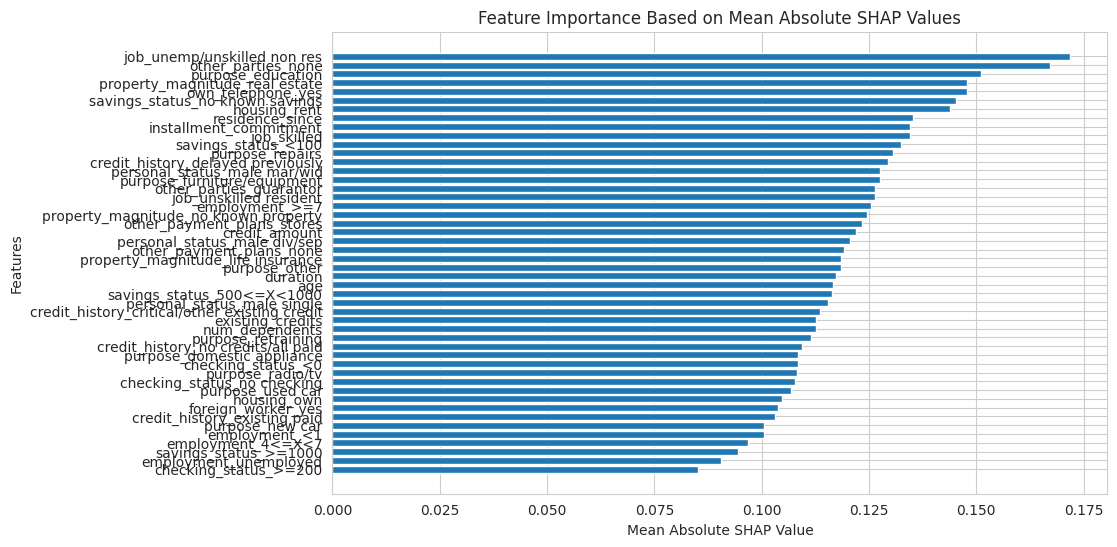

In [ ]:
if mean_abs_shap_values.ndim > 1:
    mean_abs_shap_values = mean_abs_shap_values.mean(axis=1)

feature_score_shap = {feature: mean_abs_shap_values[idx] for idx, feature in enumerate(X_train_df.columns)}

# Sort the feature importances by their mean absolute SHAP values
sorted_feature_importances = sorted(feature_score_shap.items(), key=lambda x: x[1], reverse=True)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), [score for feature, score in sorted_feature_importances], tick_label=[feature for feature, score in sorted_feature_importances])
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.title('Feature Importance Based on Mean Absolute SHAP Values')
plt.gca().invert_yaxis()  # most important feature at the top
plt.show()

### Model Optimization

#### After LIME

In [ ]:
# Drop non-influential features
drop_features_lime = ['other_parties_none', 'employment_<1']
X_train_lime = X_train_df.drop(columns = drop_features_lime)
X_test_lime = X_test_df.drop(columns = drop_features_lime)

# Logistic Regression
lime_model = LogisticRegression()
lime_model.fit(X_train_lime, y_train)

# Evaluation
y_pred_lime = lime_model.predict(X_test_lime)
y_pred_proba_lime = lime_model.predict_proba(X_test_lime)
lime_report = classification_report(y_test, y_pred_lime, target_names = class_names)
accuracy_lime = accuracy_score(y_test, y_pred_lime)
log_loss_lime = log_loss(y_test, y_pred_proba_lime)

# Results
print('Logistics Regression Evaluation\n')
print(lime_report)
print(f'Accuracy: {accuracy_lime}\nLog Loss: {log_loss_lime}')

Logistics Regression Evaluation

              precision    recall  f1-score   support

         bad       0.74      0.54      0.63        59
        good       0.83      0.92      0.87       141

    accuracy                           0.81       200
   macro avg       0.79      0.73      0.75       200
weighted avg       0.80      0.81      0.80       200

Accuracy: 0.81
Log Loss: 0.4584493361286991


#### After SHAP

In [ ]:
# Drop the identified non-influential features from the training and test sets
drop_features_shap = ['checking_status_>=200', 'employment_unemployed']
X_train_shap = X_train_df.drop(columns=drop_features_shap)
X_test_shap = X_test_df.drop(columns=drop_features_shap)

# Fit the model on the reduced feature set
shap_model = LogisticRegression()
shap_model.fit(X_train_shap, y_train)

# Make predictions with the updated model on the reduced feature test set
y_pred_shap = shap_model.predict(X_test_shap)
y_pred_proba_shap = shap_model.predict_proba(X_test_shap)

# Generate a classification report
shap_report = classification_report(y_test, y_pred_shap, target_names=class_names)

# Calculate accuracy and log loss
accuracy_shap = accuracy_score(y_test, y_pred_shap)
log_loss_shap = log_loss(y_test, y_pred_proba_shap)

# Print results
print('Logistic Regression Evaluation (SHAP-Informed Model)\n')
print(shap_report)
print(f'Accuracy: {accuracy_shap}\nLog Loss: {log_loss_shap}')

Logistic Regression Evaluation (SHAP-Informed Model)

              precision    recall  f1-score   support

         bad       0.73      0.56      0.63        59
        good       0.83      0.91      0.87       141

    accuracy                           0.81       200
   macro avg       0.78      0.74      0.75       200
weighted avg       0.80      0.81      0.80       200

Accuracy: 0.81
Log Loss: 0.4575487436413168


### Comparison

#### ROC Curve

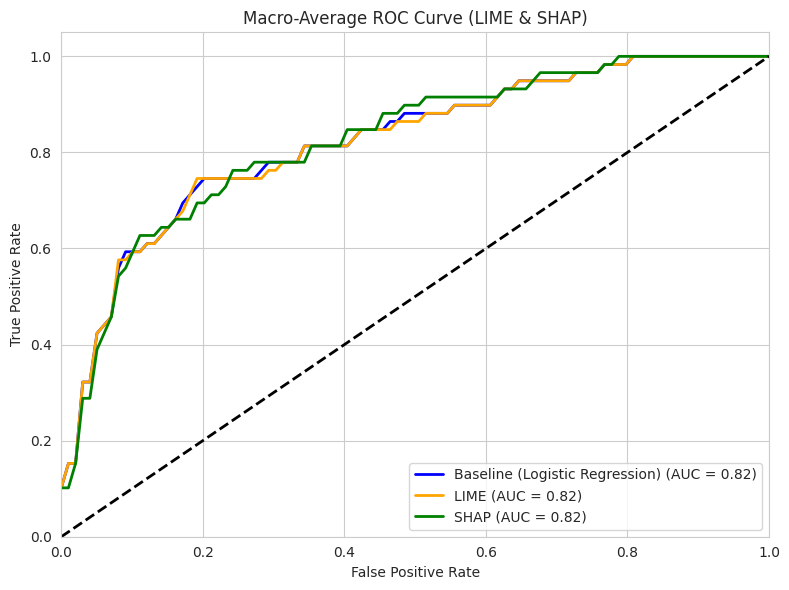

In [ ]:
# Macro-Average ROC Curve for Comparison
fig, ax = plt.subplots(figsize=(8, 6))
colors = cycle(['blue', 'orange', 'green'])

# Calculate and plot macro-average ROC curve and ROC area for each model
eml_predictions = [
    (y_pred_proba_lr, 'Baseline (Logistic Regression)'),
    (y_pred_proba_lime, 'LIME'),
    (y_pred_proba_shap, 'SHAP')
]

for model_proba, title in eml_predictions:
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)
    num_classes = y_test_binarized.shape[1]

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], model_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    mean_tpr /= num_classes
    roc_auc = auc(all_fpr, mean_tpr)
    ax.plot(all_fpr, mean_tpr, color=next(colors), lw=2, label=f'{title} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Macro-Average ROC Curve (LIME & SHAP)')
ax.legend(loc="lower right")

# Display the plot
plt.tight_layout()
plt.show()

#### Performance Metrics

In [ ]:
eml_index = ['Baseline (Logistic Regression)', 'LIME', 'SHAP']

# Performance metrics
performance_eml = {
    'Accuracy': [accuracy_lr, accuracy_lime, accuracy_shap],
    'Log Loss': [log_loss_lr, log_loss_lime, log_loss_shap],
    'ROC AUC': [
        roc_auc_score(y_test, y_pred_proba_lr[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_lime[:,1], multi_class='ovr', average='macro'),
        roc_auc_score(y_test, y_pred_proba_shap[:,1], multi_class='ovr', average='macro')
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='macro'),
        precision_score(y_test, y_pred_lime, average='macro'),
        precision_score(y_test, y_pred_shap, average='macro')
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='macro'),
        recall_score(y_test, y_pred_lime, average='macro'),
        recall_score(y_test, y_pred_shap, average='macro')
    ],
    'F1 Score (macro)': [
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_lime, average='macro'),
        f1_score(y_test, y_pred_shap, average='macro')
    ],
    'F1 Score (micro)': [
        f1_score(y_test, y_pred_lr, average='micro'),
        f1_score(y_test, y_pred_lime, average='micro'),
        f1_score(y_test, y_pred_shap, average='micro')
    ],
    'F1 Score (weighted)': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_lime, average='weighted'),
        f1_score(y_test, y_pred_shap, average='weighted')
    ]
}

eml_compare = pd.DataFrame(performance_eml, index=eml_index).sort_values(by=['Accuracy'], ascending=False)
print(eml_compare)

                                Accuracy  Log Loss   ROC AUC  Precision  \
Baseline (Logistic Regression)     0.815  0.457105  0.821854   0.788396   
LIME                               0.810  0.458449  0.820652   0.786106   
SHAP                               0.810  0.457549  0.823657   0.782796   

                                  Recall  F1 Score (macro)  F1 Score (micro)  \
Baseline (Logistic Regression)  0.745582          0.761098             0.815   
LIME                            0.732179          0.749967             0.810   
SHAP                            0.737108          0.753119             0.810   

                                F1 Score (weighted)  
Baseline (Logistic Regression)             0.807624  
LIME                                       0.800199  
SHAP                                       0.801705  


## Summary Plot

PermutationExplainer explainer: 201it [00:11,  4.77it/s]                         


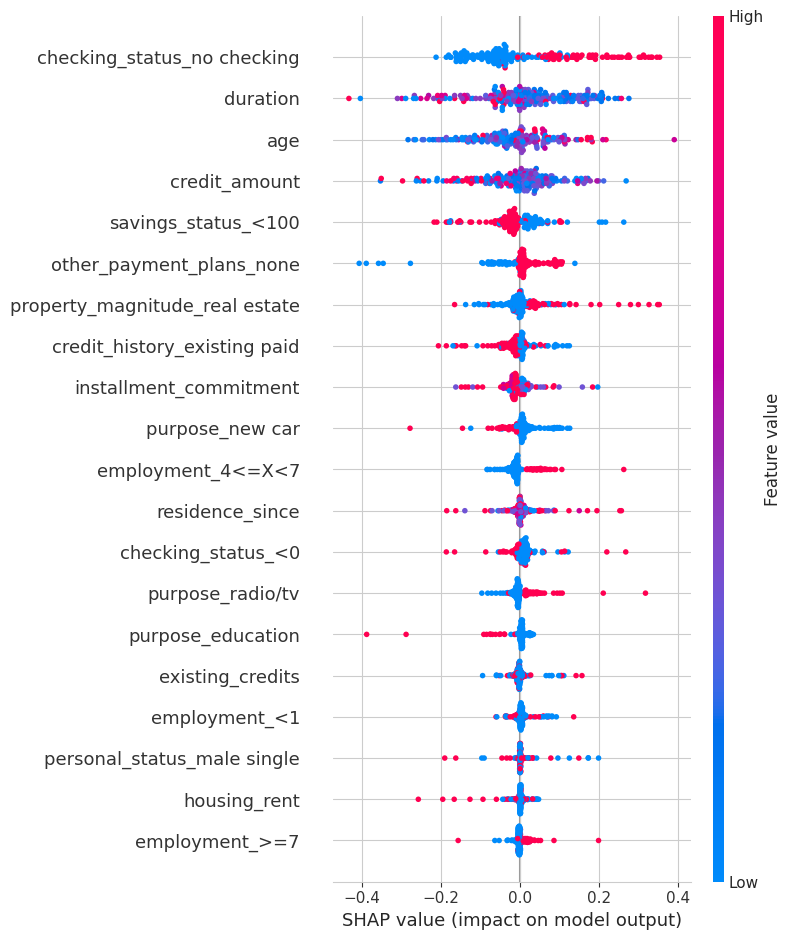

In [ ]:
# Create a SHAP explainer
explainer = shap.Explainer(shap_model.predict_proba, X_train_shap)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_shap)

# Extract SHAP values for the positive class
shap_values_pos_class = shap_values[..., 1]

# Generate and display the summary plot for the positive class
shap.summary_plot(shap_values_pos_class.values, features=X_test_shap, feature_names=X_test_shap.columns.tolist())